## Initial tests for sea ice diagnostics
François Massonnet - 3rd May 2023 - DE_340 Coding Sprint from the BSC Terrace

First, we load the usual set of modules and libraries

In [36]:
from aqua import Reader, catalogue, inspect_catalogue
from seaice_commondiags import *

Then we browse through the catalog of data. Not all available data has the sea ice variables and the requested weights  for interpolation. After playing around and looking at the repository of weights (`/work/bb1153/b382075/nextgems/weights/`) I found that the model `FESOM`, experiment `tco2559-ng5` and source `original_2d` can be regridded to `r025` (regular 1°)

In [73]:
cat = catalogue()

inspect_catalogue(cat)

Models available in catalogue:


['IFS', 'FESOM', 'ICON', 'MSWEP', 'ERA5', 'CERES', 'AVISO']

Questions open:
- To avoid confusion, wouldn't it be better to call those "datasets" since AVISO / CERES are not models and ERA5 is a reanalysis?

In [74]:
inspect_catalogue(cat, model = "FESOM")

Experiments available in catalogue for model FESOM:


['tco3999-ng5', 'tco2559-ng5', 'test-ng5', 'test-pi']

In [75]:
inspect_catalogue(cat, model = "FESOM", exp = "tco2559-ng5")

Sources available in catalogue for model FESOM and exp tco2559-ng5:


['elem_grid',
 'node_grid',
 'interpolated_global2d',
 'interpolated_global_TS',
 'interpolated_global_UV',
 'interpolated_np',
 'interpolated_sp',
 'original_2d',
 'original_3d',
 'lra-r100-mon',
 'lra-r100-day']

Now we instantiate a reader with the relevant information, asking to do the regridding and to load the grid cell areas

Questions open:

- do we have access to the land-sea mask?

In [76]:

reader = Reader(model   = "FESOM",\
                exp     = "tco2559-ng5", 
                source  = "original_2d",
                regrid  = "r100", 
                areas   = True
                )


Call the `retrieve` method to save everything into a `xarray` Dataset object  

In [77]:

data = reader.retrieve()

2023-05-03 16:16:53 :: Reader :: WARNING  -> No fixes defined for model FESOM, experiment tco2559-ng5, source original_2d


In [78]:
data

<xarray.Dataset>
Dimensions:   (time: 8328, nod2: 7402886)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20T00:56:00 ... 2020-12-31T23:56:00
Dimensions without coordinates: nod2
Data variables: (12/19)
    MLD1      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    MLD2      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    a_ice     (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmice_x  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmice_y  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmoce_x  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    ...        ...
    ssh       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    sss       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    sst       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    uice      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    vice      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    vve_5     (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
Attributes: (12/17)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       469e74b1
    FESOM_MeshPath:                      /ec/res4/scratch/natr/RAPS/20/inputs...
    FESOM_mesh_representative_checksum:  
    FESOM_ClimateDataPath:               /ec/res4/scratch/natr/RAPS/20/inputs...
    ...                                  ...
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      1
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    -1
    history:                             2023-05-03 16:16:53 retrieved by AQU...

Load a specific variable: `ci`, which is sea ice area fraction in units. Then, regrid the data to a human-readable grid defined above (`r100`)

In [82]:
dataR = reader.regrid(data["a_ice"][:100, :])
dataR

<xarray.DataArray 'a_ice' (time: 100, lat: 180, lon: 360)>
dask.array<reshape, shape=(100, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:56:00 ... 2020-01-24T03:56:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    description:  ice concentration
    long_name:    ice concentration
    units:        %
    regridded:    1
    history:      2023-05-03 16:17:29 regridded by AQUA fixer;\n

Load the grid cell areas. According to the definition of the reader function, grid_area returns the cell area of the destination grid if regridding has been performed

In [83]:
cellAreas = reader.grid_area

Screen out the variable values that are above 1 or below 0

Question:
- how to do that based on a land-sea mask?

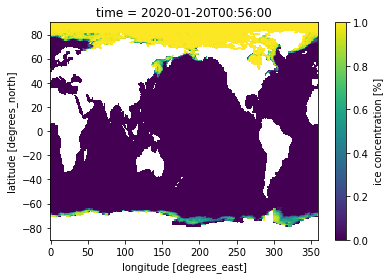

In [84]:
dataR[0,:].plot()

Compute sea ice extent (global)

In [86]:
extent = compute_extent(dataR * 100.0, cellAreas)
# Multiply 100 because the function assumes %
# Takes about 3 s per time step...

In [90]:
type(dataR)

xarray.core.dataarray.DataArray

In [ ]:

extent
